# 25. Variational AutoEncoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import random
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Load MNIST Data

In [3]:
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [4]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=1,
                                          shuffle=True)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

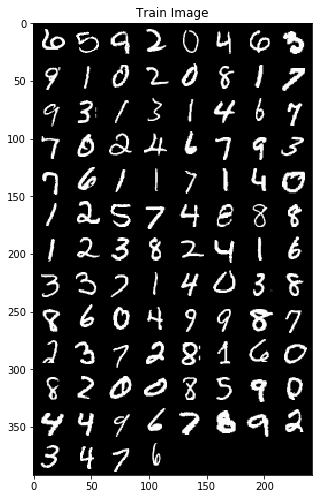

In [6]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## Define Model

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Conv2d(16,32,5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2)    # 3*3
        )
        
        # mean vector
        self.f_mu = nn.Sequential(
            nn.Linear(64*3*3, 200),
            nn.Linear(200, 50)
        )
        
        # standard deviation vector
        self.f_std_log = nn.Sequential(
            nn.Linear(64*3*3, 200),
            nn.Linear(200, 50)
        )
        
        self.relu = nn.ReLU()
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)        
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)                
        
    def encode(self, x) :
        out = self.encoder(x)
        out = out.view(-1, 64*3*3)
        out = self.relu(out)
        
        mu = self.f_mu(out)
        std_log = self.f_std_log(out)
        
        return mu, std_log
        
    def f_latent(self, mu, std_log) :
        if self.training :
            std = std_log.exp()

            # random vector
            random = torch.randn(std.shape).cuda()
            
            # z vector
            z = random * std + mu

            return z
        
        else :
            return mu
        
    def forward(self, x):
        mu, std_log = self.encode(x)
        z = self.f_latent(mu, std_log)
        
        return mu, std_log, z

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(50, 200),
            nn.Linear(200, 64*3*3)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,5,stride=2,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
#             nn.MaxUnpool2d(2,2),
            
            nn.ConvTranspose2d(32,16,4,stride=2,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
#             nn.MaxUnpool2d(2,2),
            
            nn.ConvTranspose2d(16,1,4,stride=2,padding=1),
            nn.ReLU()
        )
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, z):
        out = self.fc(z)
        out = out.view(-1,64,3,3)
        out = self.decoder(out)
        out = self.sigmoid(out)
        out = out.view(-1,1,28,28)
        
        return out

In [9]:
E = Encoder().cuda()
D = Decoder().cuda()

## 22.3 Model Training

In [10]:
reconstruction_loss = nn.BCELoss(reduction='sum')

def KLD_loss(mu, std_log) :
    var_log = 2*std_log
    return torch.sum(var_log.exp() + mu.pow(2) - 1 - var_log)/2

# Encoder & Decoder 함께 학습
optimizer = optim.Adam(list(E.parameters()) + list(D.parameters()), lr=0.001)

In [11]:
num_epochs = 100

for epoch in range(num_epochs):
    
    total_batch = len(mnist_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        
        mu, std_log, z = E(X)
        pre = D(z)
        
        cost = reconstruction_loss(pre, X) + KLD_loss(mu, std_log)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) == total_batch:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'%(epoch+1, num_epochs, i+1, total_batch, cost.item()))
            
print("Learning Finished!")

Epoch [1/100], lter [600/600] Loss: 58096.3320
Epoch [2/100], lter [600/600] Loss: 56444.3125
Epoch [3/100], lter [600/600] Loss: 54633.3242
Epoch [4/100], lter [600/600] Loss: 53824.5547
Epoch [5/100], lter [600/600] Loss: 53648.7344
Epoch [6/100], lter [600/600] Loss: 53936.1562
Epoch [7/100], lter [600/600] Loss: 53611.3633
Epoch [8/100], lter [600/600] Loss: 53484.4570
Epoch [9/100], lter [600/600] Loss: 53604.7734
Epoch [10/100], lter [600/600] Loss: 53643.5586
Epoch [11/100], lter [600/600] Loss: 53275.0625
Epoch [12/100], lter [600/600] Loss: 53413.6406
Epoch [13/100], lter [600/600] Loss: 53325.7578
Epoch [14/100], lter [600/600] Loss: 53369.9766
Epoch [15/100], lter [600/600] Loss: 53421.2422
Epoch [16/100], lter [600/600] Loss: 53121.5547
Epoch [17/100], lter [600/600] Loss: 53122.7539
Epoch [18/100], lter [600/600] Loss: 53035.1641
Epoch [19/100], lter [600/600] Loss: 53103.6445
Epoch [20/100], lter [600/600] Loss: 52890.8203
Epoch [21/100], lter [600/600] Loss: 53273.6445
E

## 22.4 Test Model

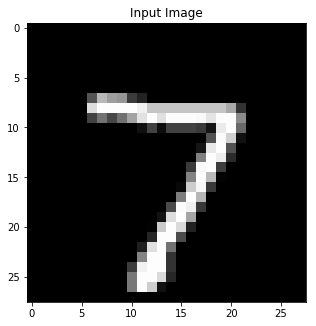

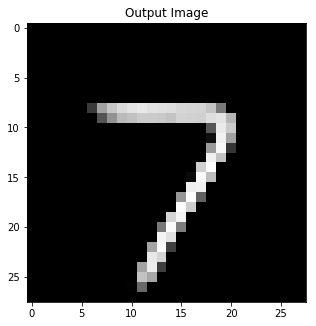

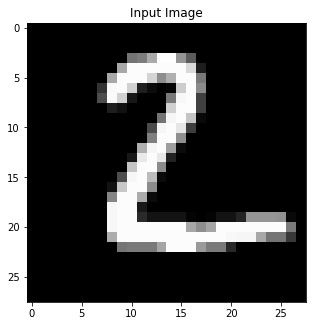

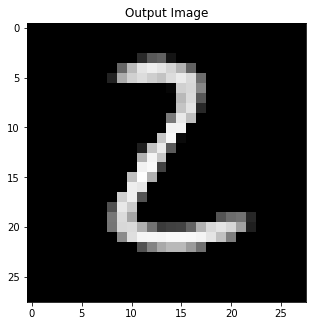

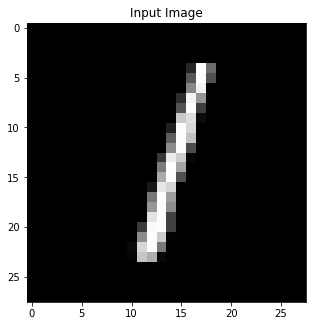

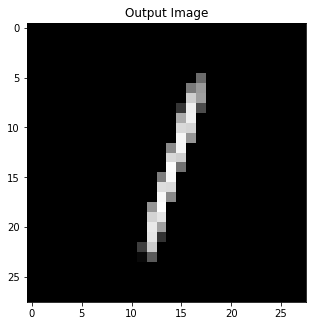

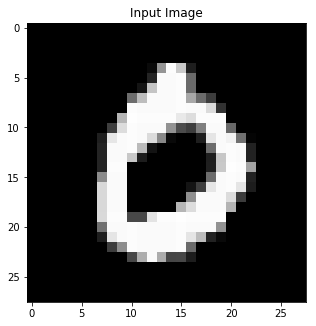

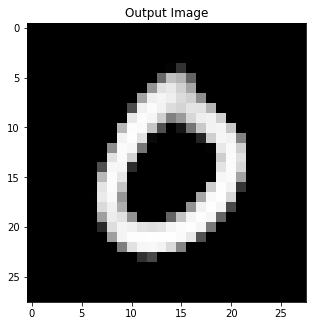

In [12]:
E.eval()
D.eval()

for n, (images, labels) in enumerate(mnist_test):
    
    imshow(torchvision.utils.make_grid(images, normalize=True), "Input Image")
    
    images = images.view(-1, 1, 28, 28).cuda()
    
    mu, std_log, z = E(images)
    outputs = D(z)
    outputs = outputs.view(-1, 1, 28, 28)
    
    imshow(torchvision.utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")
    
    if n > 2 : break